<h2>Comparison between EC and RS</h2>

<h2>1. Import package and define function</h2>

In [ ]:
# PACKAGE
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import geemap
import ee
from calendar import monthrange
from statsmodels.tools.eval_measures import rmse

# Authenticate and Initialize GEE
ee.Authenticate()
ee.Initialize()

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [2]:
# FUNCTION
def ols(data1,data2):
    x = sm.add_constant(data1)
    y = data2
    mlr = sm.OLS(y,x).fit()
    y_pred = mlr.predict(x)
    return (mlr.rsquared,rmse(y,y_pred))

<h2>2. Pre-processing input</h2>

In [ ]:
# EC data
EC = (pd.read_csv('./Data/EC data.csv').set_index(pd.date_range(start="2011-10-01",end="2022-10-31",freq="MS",inclusive="left")).rename(columns={'Et':'EC'}))

# GEE

# Tower location
Tower_location = ee.Geometry.Point([115.71365, -31.37641])

# Add map
Map = geemap.Map()

# Shapefile
Tower_whole = ee.FeatureCollection(json.loads(gpd.read_file('./Shapefile/Tower_footprint.shp',engine='pyogrio').to_crs(4326).to_json()))

# Arguments to filter the image collection
# Start date
start_date = '2011-10-01'
startDate = ee.Date.parse('YYYY-MM-dd',start_date)
# End date
end_date = '2022-11-01'
endDate = ee.Date.parse('YYYY-MM-dd',end_date)

# Functions
# Clip function
def clip_fnc(image):
    return image.clip(Tower_whole.geometry())

# Count band function
def count_band_fnc(image):
    band_no_var = image.bandNames().size()
    return image.copyProperties(image).set({'band_no':band_no_var})

# Count properties function
def count_property_fnc(image):
    property_no_var = image.propertyNames().size()
    return image.set({'property_no':property_no_var})

# Extract bit function
def bitWiseExtract(input, fromBit, toBit):
    maskSize = ee.Number(1).add(toBit).subtract(fromBit)
    mask = ee.Number(1).leftShift(maskSize).subtract(1)
    return input.rightShift(fromBit).bitwiseAnd(mask)

# Pixel area function
def pixel_area_fnc(image):
    pixel_area_var = ee.Image.pixelArea()
    image_to_use_var = image.select(0)
    image_to_use_mask = image_to_use_var.gt(0)
    image_to_use_area = pixel_area_var.updateMask(image_to_use_mask)
    area_var = image_to_use_area.reduceRegion(reducer = ee.Reducer.sum(), geometry = Tower_whole.geometry())
    return image.set({'pixel_area':area_var.get('area')})

In [4]:
# CMRSET
# Define QA function
def cmrset_QA_fnc(image):
    cmrset_qa_var = image.select('pixel_qa')
    cmrset_mask_var = bitWiseExtract(cmrset_qa_var,0,1).eq(3)
    return image.updateMask(cmrset_mask_var)

# Filter collection
cmrset = (ee.ImageCollection('TERN/AET/CMRSET_LANDSAT_V2_2')
          .filterBounds(Tower_whole.geometry())
          .filterDate(start_date,end_date)
          .select([0,1],["ET","pixel_qa"])
          .map(cmrset_QA_fnc)
          .map(lambda image: image.set({'ET_value':image.reduceRegion(reducer = ee.Reducer.mean(), geometry = Tower_whole.geometry(), scale = 30, maxPixels = 1e9).get('ET')}))
          .map(count_property_fnc)
          .filterMetadata('property_no','equals',10))

# Generate a dataframe
cmrset_df = (pd.DataFrame(list(zip(cmrset.aggregate_array('system:time_start').getInfo(), cmrset.aggregate_array('ET_value').getInfo())), columns=['Datetime','ET'])
             .set_index(pd.date_range(start="2011-10-01",end="2022-10-31",freq="MS",inclusive="left")).drop(columns=['Datetime']).rename(columns={'ET':'CMRSET'}))

# MOD16A2 (use MOD16A2.006 rather than MOD16A2.061 as the newer only covers from 2021) 

# Define QA function
def mod16a2_QA_fnc(image):
    mod16a2_qa_var = image.select('pixel_qa')
    mod16a2_mask_qc_var = bitWiseExtract(mod16a2_qa_var,0,0).eq(0)
    mod16a2_mask_sensor_var = bitWiseExtract(mod16a2_qa_var,1,1).eq(0)
    mod16a2_mask_cloud_state_var = bitWiseExtract(mod16a2_qa_var,3,4).eq(0)
    mod16a2_mask_confidence_var = bitWiseExtract(mod16a2_qa_var,5,7).lte(1)
    mod16a2_mask_var = mod16a2_mask_qc_var.add(mod16a2_mask_sensor_var).add(mod16a2_mask_cloud_state_var).add(mod16a2_mask_confidence_var)
    return image.updateMask(mod16a2_mask_var)

# Define conversion calculation
def mod16a2_convert(image):
    
    # Converted ET
    et_converted = image.expression('(ET*0.1)/8',{'ET':image.select('ET')}).rename('ET_converted')
    
    image = image.addBands(et_converted)
    return image

# Filter collection 
mod16a2 = (ee.ImageCollection('MODIS/006/MOD16A2')
           .filterBounds(Tower_whole.geometry())
           .filterDate(start_date,end_date)
           .select([0,4],["ET","pixel_qa"])
           .map(mod16a2_QA_fnc)
           .map(mod16a2_convert)
           .map(lambda image: image.set({'ET_value':image.reduceRegion(reducer = ee.Reducer.mean(), geometry = Tower_whole.geometry(), scale = 500, maxPixels = 1e9).get('ET_converted')}))
           .map(count_property_fnc)
           .filterMetadata('property_no','equals',11))

# Generate a dataframe
mod16a2_df = pd.DataFrame(list(zip(mod16a2.aggregate_array('system:time_start').getInfo(), mod16a2.aggregate_array('ET_value').getInfo())), columns=['Datetime','ET'])
mod16a2_df = mod16a2_df.set_index(pd.to_datetime(mod16a2_df['Datetime'], unit='ms')).drop(['Datetime'], axis=1).resample('MS').mean().rename(columns={'ET':'MOD16'})

# PML

# Filter collection 
pml = (ee.ImageCollection('CAS/IGSNRR/PML/V2_v017')
       .filterBounds(Tower_whole.geometry())
       .filterDate(start_date,end_date)
       .select(["Ec","Es","Ei"],["ETc","ETs","ETi"])
       .map(lambda image: image.set({'ETc_value':image.reduceRegion(reducer = ee.Reducer.mean(), geometry = Tower_whole.geometry(), scale = 500, maxPixels = 1e9).get('ETc'),
                                     'ETs_value':image.reduceRegion(reducer = ee.Reducer.mean(), geometry = Tower_whole.geometry(), scale = 500, maxPixels = 1e9).get('ETs'),
                                     'ETi_value':image.reduceRegion(reducer = ee.Reducer.mean(), geometry = Tower_whole.geometry(), scale = 500, maxPixels = 1e9).get('ETi')}))
       .map(count_property_fnc)
       .filterMetadata('property_no','equals',9))

# Generate a dataframe ('system:time_start' has error, use code editor)
pml_df = pd.DataFrame(list(zip(pml.aggregate_array('system:time_start').getInfo(), pml.aggregate_array('ETc_value').getInfo(), 
                               pml.aggregate_array('ETs_value').getInfo(), pml.aggregate_array('ETi_value').getInfo())), columns=['Datetime','ETc','ETs','ETi'])
pml_df = pml_df.set_index(pd.to_datetime(pml_df['Datetime'], unit='ms')).drop(['Datetime'], axis=1).resample('MS').mean()
pml_df['PML'] = pml_df['ETc'] + pml_df['ETs'] + pml_df['ETi']

<h2>3. Plot</h2>

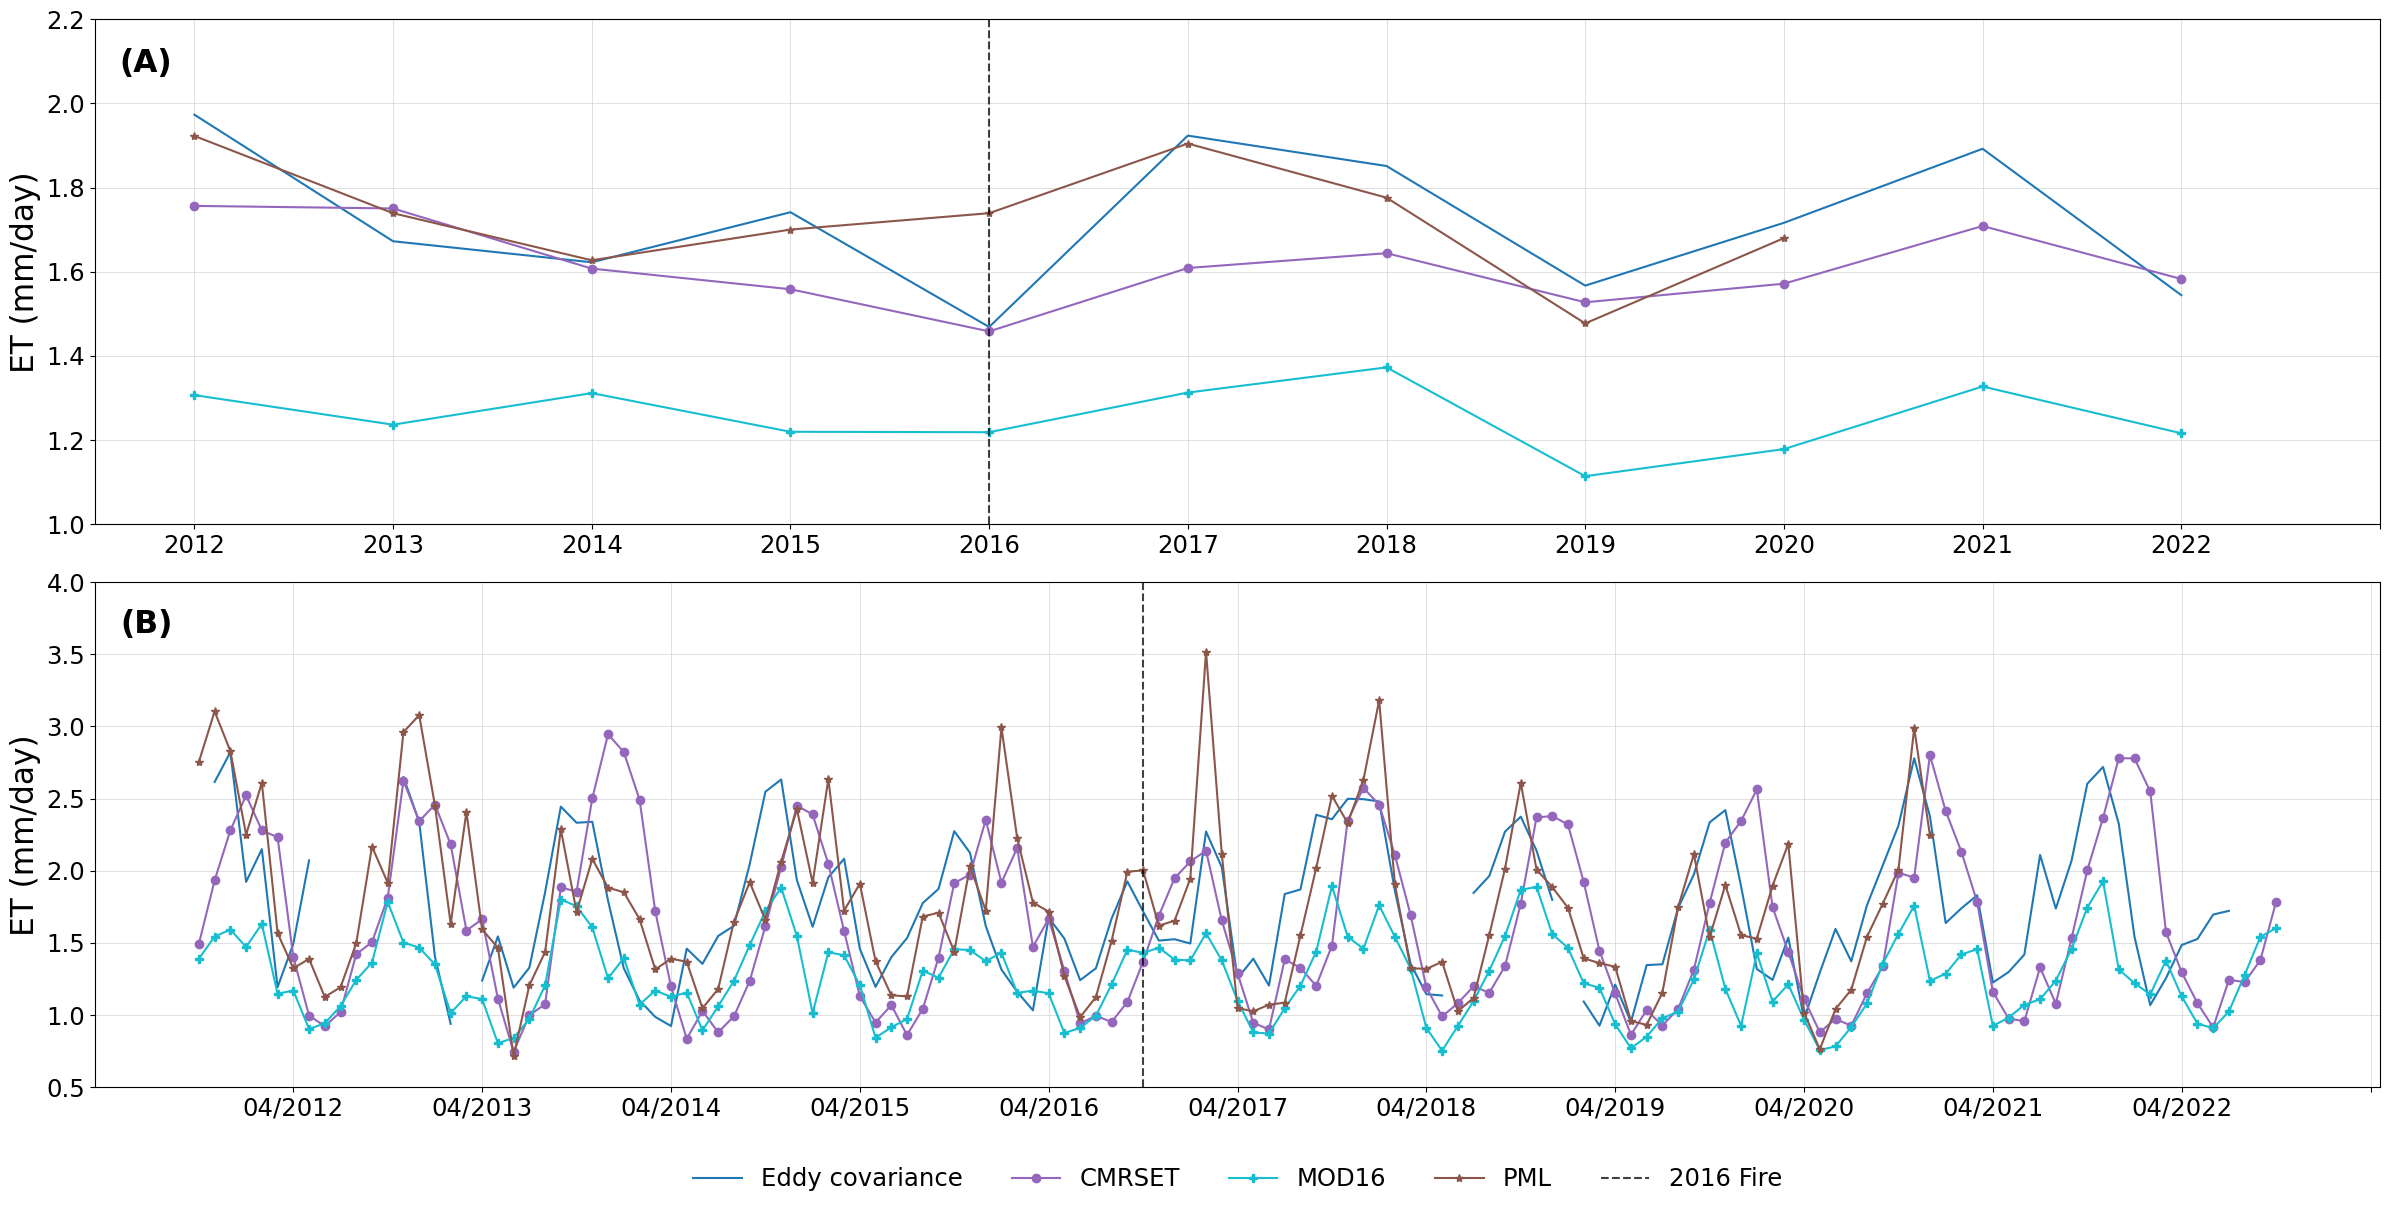

In [ ]:
# Monthly and annually combine
combine_monthly = pd.concat([EC['2011-10-01':'2022-10-01']['EC'],cmrset_df['2011-10-01':'2022-10-01']['CMRSET'],
                             mod16a2_df['2011-10-01':'2022-10-01']['MOD16'],pml_df['2011-10-01':'2022-10-01']['PML']],axis=1)
combine_monthly.columns = ['EC','CMRSET','MOD16','PML']
combine_annually = combine_monthly['2012-01-01':'2022-10-01'].resample('Y',origin='start_day').mean().reset_index(drop=True).set_index(pd.date_range('2012-10-01',periods=11,freq='12MS'))

# Combined plot
plt.figure(figsize=(24,12))

# Annual plot
plt.subplot(2,1,1)
plt.plot(combine_annually.index.to_series().dt.strftime('%Y'),combine_annually['EC'],alpha=1,label='Eddy covariance',color='tab:blue')
plt.plot(combine_annually.index.to_series().dt.strftime('%Y'),combine_annually['CMRSET'],alpha=1,label='CMRSET',marker='o',color='tab:purple')
plt.plot(combine_annually.index.to_series().dt.strftime('%Y'),combine_annually['MOD16'],alpha=1,label='MOD16',marker='P',color='tab:cyan')
plt.plot(combine_annually.index.to_series().dt.strftime('%Y'),combine_annually['PML'],alpha=1,label='PML',marker='*',color='tab:brown')
plt.axvline(x=dt.datetime(2016,10,1).strftime('%Y'),linestyle='--',linewidth=1.5,c='black',alpha=0.75,label='2016 Fire')
plt.ylim(1.0,2.2)
plt.xticks(np.arange(0,len(combine_annually.index)+1,1),fontsize=17.5)
plt.yticks(fontsize=17.5)
plt.grid(color='lightgray',linewidth=0.5)
plt.text(-0.375,2.075,'(A)',fontsize=22.5,fontweight='bold')
plt.ylabel('ET (mm/day)',fontsize=22.5)

# Monthly plot
plt.subplot(2,1,2)
plt.plot(combine_monthly.index.to_series().dt.strftime('%m/%Y'),combine_monthly['EC'],alpha=1,label='Eddy covariance',color='tab:blue')
plt.plot(combine_monthly.index.to_series().dt.strftime('%m/%Y'),combine_monthly['CMRSET'],alpha=1,label='CMRSET',marker='o',color='tab:purple')
plt.plot(combine_monthly.index.to_series().dt.strftime('%m/%Y'),combine_monthly['MOD16'],alpha=1,label='MOD16',marker='P',color='tab:cyan')
plt.plot(combine_monthly.index.to_series().dt.strftime('%m/%Y'),combine_monthly['PML'],alpha=1,label='PML',marker='*',color='tab:brown')
plt.axvline(x=dt.datetime(2016,10,1).strftime('%m/%Y'),linestyle='--',linewidth=1.5,c='black',alpha=0.75,label='2016 Fire')
plt.ylim(0.5,4)
plt.xticks(np.arange(6,len(combine_monthly.index)+12,12),fontsize=17.5)
plt.yticks(fontsize=17.5)
plt.grid(color='lightgray',linewidth=0.5)
plt.text(-5,3.65,'(B)',fontsize=22.5,fontweight='bold')
plt.ylabel('ET (mm/day)',fontsize=22.5)
plt.legend(loc='lower center',ncol=6,fontsize=17.5,bbox_to_anchor=(0.5,-0.25),frameon=False)

plt.tight_layout()
plt.savefig('Combined comparison annual - monthly (EC - RS).png')

<h2>4. Performance metrics</h2>

In [ ]:
# CONFUSION MATRIX TYPE REPORT TABLE FOR R2 AND RMSE

# Combine for loop
combine_for_loop = [combine_monthly,combine_annually]

# Column and index for report table
combine_for_loop_name = ['EC','CMRSET','MOD16','PML']

# Empty dfs for report 
combine_r2_monthly = pd.DataFrame(np.zeros((len(combine_for_loop_name),len(combine_for_loop_name)))*np.nan,index=combine_for_loop_name,columns=combine_for_loop_name)
combine_r2_annually = pd.DataFrame(np.zeros((len(combine_for_loop_name),len(combine_for_loop_name)))*np.nan,index=combine_for_loop_name,columns=combine_for_loop_name)
combine_r2 = [combine_r2_monthly,combine_r2_annually]

combine_rmse_monthly = pd.DataFrame(np.zeros((len(combine_for_loop_name),len(combine_for_loop_name)))*np.nan,index=combine_for_loop_name,columns=combine_for_loop_name)
combine_rmse_annually = pd.DataFrame(np.zeros((len(combine_for_loop_name),len(combine_for_loop_name)))*np.nan,index=combine_for_loop_name,columns=combine_for_loop_name)
combine_rmse = [combine_rmse_monthly,combine_rmse_annually]

# Loop
for x in range(len(combine_for_loop)):
    
    # Select which df for further steps
    combine_x = combine_for_loop[x]
    
    for y in range(len(combine_x.columns)):
        
        # Bring the needed column upfront
        combine_x_y = combine_x.copy()
        combine_x_y.insert(0,combine_x_y.columns[y],combine_x_y.pop(combine_x_y.columns[y]))
        
        for z in range(len(combine_x_y.columns)):
            
            if z == 0:
                
                # Calculate performance metrics of the needed column with the others
                r2_, rmse_ = ols(combine_x_y[combine_x_y.columns[0]].dropna(axis=0),combine_x_y[combine_x_y.columns[0]].dropna(axis=0))
                
                # Report
                combine_r2[x][combine_x_y.columns[0]][combine_x_y.columns[0]] = r2_
                combine_rmse[x][combine_x_y.columns[0]][combine_x_y.columns[0]] = rmse_
                
            else:
                
                # Calculate performance metrics of the needed column with the others
                R2_, RMSE_ = ols(combine_x_y.loc[:,[combine_x_y.columns[0],combine_x_y.columns[0+z]]].dropna(axis=0)[combine_x_y.columns[0+z]],
                                 combine_x_y.loc[:,[combine_x_y.columns[0],combine_x_y.columns[0+z]]].dropna(axis=0)[combine_x_y.columns[0]])
                
                # Report
                combine_r2[x][combine_x_y.columns[0]][combine_x_y.columns[0+z]] = R2_
                combine_rmse[x][combine_x_y.columns[0]][combine_x_y.columns[0+z]] = RMSE_
                
# R2 - Merge monthly with annually (monthly up, annually down)
combine_r2_merge = combine_r2_monthly.copy()
combine_r2_merge.loc[['CMRSET'],['EC','CMRSET']] = combine_r2_annually.loc[['CMRSET'],['EC','CMRSET']]
combine_r2_merge.loc[['MOD16'],['EC','CMRSET','MOD16']] = combine_r2_annually.loc[['MOD16'],['EC','CMRSET','MOD16']]
combine_r2_merge.loc[['PML'],['EC','CMRSET','MOD16','PML']] = combine_r2_annually.loc[['PML'],['EC','CMRSET','MOD16','PML']]

# RMSE - Merge monthly with annually
combine_rmse_merge = combine_rmse_monthly.copy()
combine_rmse_merge.loc[['CMRSET'],['EC','CMRSET']] = combine_rmse_annually.loc[['CMRSET'],['EC','CMRSET']]
combine_rmse_merge.loc[['MOD16'],['EC','CMRSET','MOD16']] = combine_rmse_annually.loc[['MOD16'],['EC','CMRSET','MOD16']]
combine_rmse_merge.loc[['PML'],['EC','CMRSET','MOD16','PML']] = combine_rmse_annually.loc[['PML'],['EC','CMRSET','MOD16','PML']]

# RMSE - Set too small value to 0
combine_rmse_merge[(abs(combine_rmse_merge) < 10**(-10))] = 0

# RMSE - Normalise df by mean EC ET
combine_rmse_merge = combine_rmse_merge.div(combine_monthly['EC'].mean())

# Export
combine_r2_merge.to_csv('Comparison R2.csv')
combine_rmse_merge.to_csv('Comparison rmse.csv')